In [148]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.nddata import Cutout2D
from astropy.visualization import simple_norm
from astropy.stats import sigma_clipped_stats
from astropy.wcs.utils import proj_plane_pixel_scales
import os
from astropy.modeling import models, fitting

In [2]:
with open('data/SMSS 072242.59-390159.6/J/quad.reg') as f:
    for line in f:
        pass

        # print(line)
    # text = f.readline÷s()
line = line.split('(')[1].split(')')[0].split(',')
ra = float(line[0])
dec = float(line[1])
coords = SkyCoord(ra=ra, dec=dec, unit=(u.deg, u.deg), frame='icrs')
coords

<SkyCoord (ICRS): (ra, dec) in deg
    (110.6774756, -39.0332252)>

In [109]:
scan =os.scandir('data/SMSS 072242.59-390159.6/DES')
def_files = [x.path for x in scan if x.name.endswith('.fits')]
def_files, len(def_files)


(['data/SMSS 072242.59-390159.6/DES/c4d_190209_033007_oki_g_v1_extn=49_POS=110.6774756,-39.0332252_SIZE=0.02,0.02.fits',
  'data/SMSS 072242.59-390159.6/DES/c4d_190209_033205_ooi_r_v1_extn=49_POS=110.6774756,-39.0332252_SIZE=0.02,0.02.fits',
  'data/SMSS 072242.59-390159.6/DES/c4d_200307_043255_oki_i_v1_extn=8_POS=110.6774756,-39.0332252_SIZE=0.02,0.02.fits',
  'data/SMSS 072242.59-390159.6/DES/c4d_200208_053930_ooi_i_v1_extn=49_POS=110.6774756,-39.0332252_SIZE=0.02,0.02.fits',
  'data/SMSS 072242.59-390159.6/DES/c4d_200307_043255_ooi_i_v1_extn=8_POS=110.6774756,-39.0332252_SIZE=0.02,0.02.fits',
  'data/SMSS 072242.59-390159.6/DES/c4d_200208_053930_oki_i_v1_extn=49_POS=110.6774756,-39.0332252_SIZE=0.02,0.02.fits',
  'data/SMSS 072242.59-390159.6/DES/c4d_190209_033007_ooi_g_v1_extn=49_POS=110.6774756,-39.0332252_SIZE=0.02,0.02.fits',
  'data/SMSS 072242.59-390159.6/DES/c4d_190209_033205_oki_r_v1_extn=49_POS=110.6774756,-39.0332252_SIZE=0.02,0.02.fits',
  'data/SMSS 072242.59-390159.6/DE

In [183]:
idx = 9
hdul = fits.open(def_files[idx])
wcs = WCS(hdul[0].header)
mean, median, std = sigma_clipped_stats(hdul[0].data, sigma=2.0)
data = hdul[0].data

# hdul.close()
mean, median, std
pixel_scales = proj_plane_pixel_scales(wcs) * 3600.0
scale = np.mean(pixel_scales)
# pixel_scales
band = hdul[0].header['BAND']
obs_time = hdul[0].header['DATE-OBS']
exposure = hdul[0].header['EXPTIME'] # in seconds
fwhm = hdul[0].header['FWHM']
fwhm_arcsec = fwhm * scale
n = hdul[0].header['NAXIS1']

print(f"Index: {idx}")
print(f"Filter: {band}")
print(f"Scale: {scale:.2f} arcsec/pixel")
print(f"Background: {mean:.2f} ADU")
print(f"Exposure time: {exposure:.2f} s")
print(f"Observation time: {obs_time}")
print(f"FWHM: {fwhm_arcsec:.2f} arcsec")
print()


Index: 9
Filter: r
Scale: 0.26 arcsec/pixel
Background: 260.74 ADU
Exposure time: 90.00 s
Observation time: 2019-02-08T04:58:19.679441
FWHM: 0.69 arcsec



the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


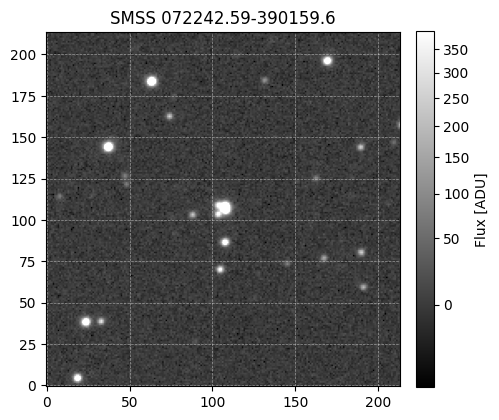

In [160]:
plt.figure(figsize=(5, 5))
# plt.subplot(projection=wcs)
norm = simple_norm(data - mean, 'sqrt', percent=99.5)
plt.imshow(data - mean, origin='lower', cmap='gray', 
           norm=norm)

# plt.grid(color='white', ls='--', lw=0.5, alpha=0.5)
# plt.xlabel('RA')
# plt.ylabel('Dec')
plt.title('SMSS 072242.59-390159.6')
plt.colorbar(label='Flux [ADU]', fraction=0.046, pad=0.04)
plt.grid(color='white', ls='--', lw=0.5, alpha=0.5)
plt.show()

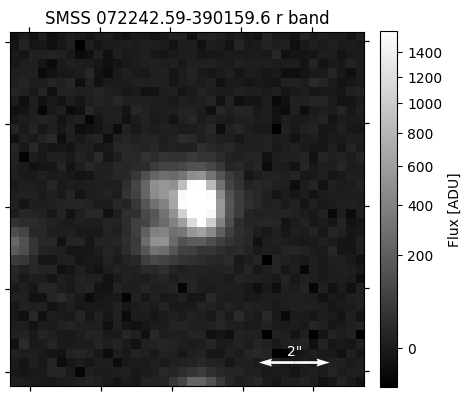

In [161]:
rad = 10 * u.arcsec
cutout = Cutout2D(hdul[0].data - mean, coords, rad, wcs=wcs)

plt.figure(figsize=(5, 5))
plt.subplot(projection=cutout.wcs)
plt.imshow(cutout.data, origin='lower', cmap='gray', 
           norm=simple_norm(cutout.data, 'sqrt', percent=99.))
plt.colorbar(label='Flux [ADU]', fraction=0.046, pad=0.04)

v_location = [30, 2]
v = [0.1, 0]

v_temp = np.concatenate([np.array(v_location), np.array(v)])
v_q = plt.quiver(*v_temp, scale=1, color='white')

v_temp = np.concatenate([np.array(v_location), -np.array(v)])
v_q = plt.quiver(*v_temp, scale=1, color='white')

plt.annotate('2"', xy=(30, 2.5), va='bottom', ha='center',
             color='white')

plt.xlabel('RA')
plt.ylabel('Dec')
plt.title(f'SMSS 072242.59-390159.6 {band} band')
# plt.grid(color='cyan', ls='--', lw=0.5, alpha=0.5)
plt.show()

# Fitting PSF

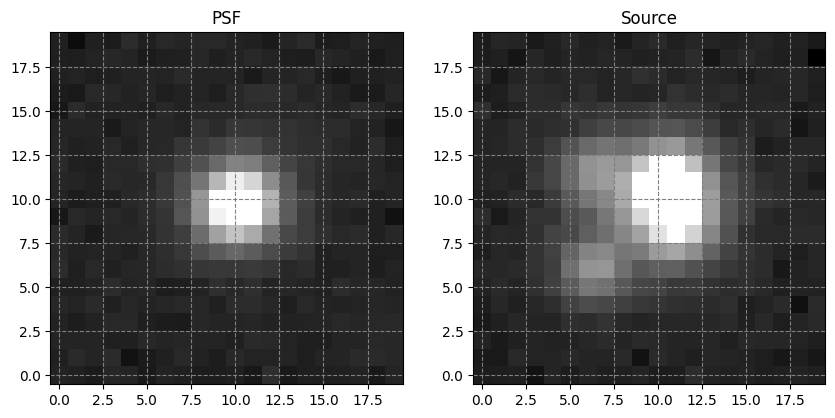

In [184]:
# Gaia DR3 5585882938732692608
# ra, dec, mag = 110.68099912622897, -39.038275911889805, 19.5907

plt.figure(figsize=(10, 5))
ax1 = plt.subplot(121)
norm = simple_norm(data - mean, 'sqrt', percent=99.9)
psf = Cutout2D(data - mean, (37, 144), size=(20, 20))
ax1.imshow(psf.data, origin='lower', cmap='gray', norm=norm)
ax1.grid(True, color='gray', linestyle='--')
ax1.set_title('PSF')
ax2 = plt.subplot(122)
norm = simple_norm(data - mean, 'sqrt', percent=99.9)
src = Cutout2D(data - mean, (n / 2, n / 2), size=(20, 20))
ax2.imshow(src.data, origin='lower', cmap='gray', norm=norm)
ax2.grid(True, color='gray', linestyle='--')
ax2.set_title('Source')
plt.show()

Model: CompoundModel
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Const2D(amplitude=4.03646999)>

    [1]: <Moffat2D(amplitude=2701.47294674, x_0=10.16327283, y_0=9.6804551, gamma=2.96766381, alpha=4.)>
Parameters:
       amplitude_0       amplitude_1     ...      gamma_1      alpha_1
    ----------------- ------------------ ... ----------------- -------
    4.036469985761733 2701.4729467398447 ... 2.967663813039684     4.0


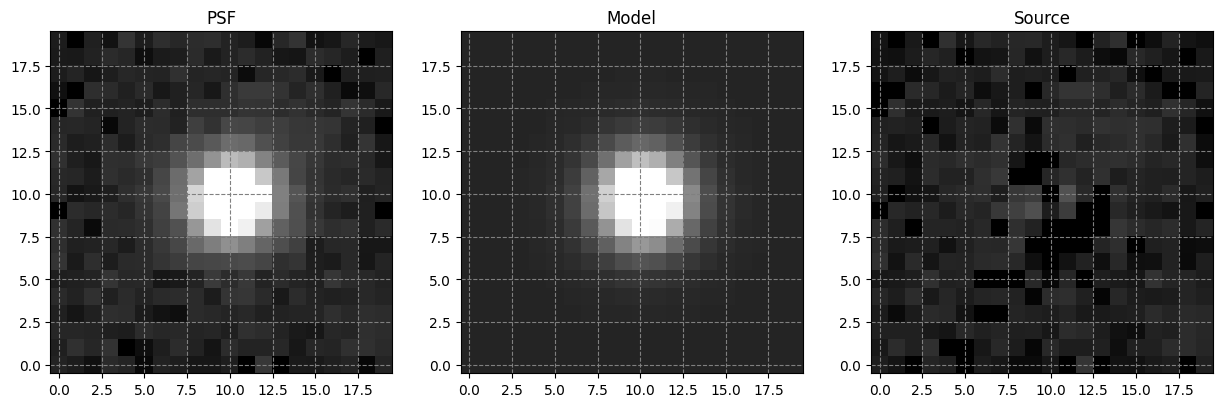

In [191]:
fit_r = fitting.LevMarLSQFitter()
model_init = models.Const2D(amplitude=0.0,
                            # fixed={'amplitude': True}
                            )
model_init += models.Moffat2D(amplitude=psf.data.max(),
                                 x_0=psf.center_cutout[0],
                                 y_0=psf.center_cutout[1],
                                 gamma=4,
                                 alpha=4,
                                 fixed={'alpha': True}
                                 )
y, x = np.mgrid[:20, :20]
model_psf = fit_r(model_init, x, y, psf.data)
print(model_psf)

fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(131)
norm = simple_norm(psf.data, 'sqrt', percent=95.0)
ax1.imshow(psf.data, origin='lower', cmap='gray', norm=norm)
ax1.grid(True, color='gray', linestyle='--')
ax1.set_title('PSF')
ax2 = fig.add_subplot(132)
ax2.imshow(model_psf(x, y), origin='lower', cmap='gray', norm=norm)
ax2.grid(True, color='gray', linestyle='--')
ax2.set_title('Model')
ax3 = fig.add_subplot(133)
residual = psf.data - model_psf(x, y)
ax3.imshow(residual, origin='lower', cmap='gray', norm=norm)
ax3.grid(True, color='gray', linestyle='--')
ax3.set_title('Source')
plt.show()

In [252]:
psf_g_mag = 19.5907
psf_flux = model_psf.amplitude_1 * np.pi * model_psf.gamma_1 ** 2
print(f"Flux: {psf_flux:.1f}, Mag: {psf_g_mag:.2f}, FWHM: {model_psf[1].fwhm * scale:.2f}")

Flux: 74744.6, Mag: 19.59, FWHM: 0.68


# Fitting source images with PSF model

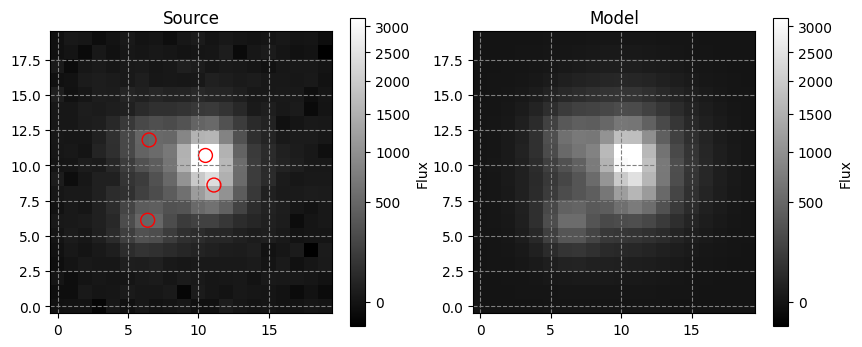

Model: CompoundModel
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Expression: [0] + [1] + [2] + [3] + [4] + [5]
Components: 
    [0]: <Const2D(amplitude=0., name='const')>

    [1]: <Moffat2D(amplitude=3208.94433594, x_0=10.5, y_0=10.7, gamma=2.96766381, alpha=4., name='moffat_1')>

    [2]: <Moffat2D(amplitude=1283.57775879, x_0=11.1, y_0=8.6, gamma=2.96766381, alpha=4., name='moffat_2')>

    [3]: <Moffat2D(amplitude=534.82403564, x_0=6.4, y_0=6.1, gamma=2.96766381, alpha=4., name='moffat_3')>

    [4]: <Moffat2D(amplitude=534.82403564, x_0=6.5, y_0=11.8, gamma=2.96766381, alpha=4., name='moffat_4')>

    [5]: <Gaussian2D(amplitude=320.8944397, x_mean=10., y_mean=10., x_stddev=3., y_stddev=3., theta=0., name='gaussian_5')>
Parameters:
    amplitude_0   amplitude_1   x_0_1 y_0_1 ... x_stddev_5 y_stddev_5 theta_5
    ----------- --------------- ----- ----- ... ---------- ---------- -------
            0.0 3208.9443359375  10.5  10.7 ...        3.0        3.0     0.0


In [207]:
model_init = models.Const2D(amplitude=0.0,
                            fixed={'amplitude': False},
                            name='const')
components = {
    1: {'name': 'Moffat2D', 'amplitude': src.data.max()/1, 'x_0': 10.5, 'y_0': 10.7},
    2: {'name': 'Moffat2D', 'amplitude': src.data.max()/2.5, 'x_0': 11.1, 'y_0': 8.6},
    3: {'name': 'Moffat2D', 'amplitude': src.data.max()/6, 'x_0': 6.4, 'y_0': 6.1},
    4: {'name': 'Moffat2D', 'amplitude': src.data.max()/6, 'x_0': 6.5, 'y_0': 11.8},
    5: {'name': 'Gaussian2D', 'amplitude': src.data.max()/10, 'x_mean': 10.0, 'y_mean': 10.0,
        'x_stddev': 3.0, 'y_stddev': 3.0, 'theta': 0.0}
}

y, x = np.mgrid[:20, :20]

plt.figure(figsize=(10, 5))
ax1 = plt.subplot(121)
norm = simple_norm(src.data, 'sqrt', percent=99.5)
cb = ax1.imshow(src.data, origin='lower', cmap='gray', norm=norm)
for i, component in components.items():
    if component['name'] == 'Moffat2D':
        model_init += models.Moffat2D(amplitude=component['amplitude'],
            x_0=component['x_0'],
            y_0=component['y_0'],
            gamma=model_psf.gamma_1.value,
            alpha=model_psf.alpha_1.value,
            fixed={'alpha': True, 'gamma': True},
            name=f"moffat_{i}"
            )
        ax1.scatter(component['x_0'], component['y_0'], 
                    s=100, edgecolor='red', facecolor='none'
                    )
    elif component['name'] == 'Gaussian2D':
        model_init += models.Gaussian2D(amplitude=component['amplitude'],
            x_mean=component['x_mean'],
            y_mean=component['y_mean'],
            x_stddev=component['x_stddev'],
            y_stddev=component['y_stddev'],
            theta=component['theta'],
            name=f"gaussian_{i}"
            )
ax1.grid(True, color='gray', linestyle='--')
plt.colorbar(cb, label='Flux', orientation='vertical', shrink=0.8, ax=ax1)
ax1.set_title('Source')
ax2 = plt.subplot(122)
cb = ax2.imshow(model_init(x, y), origin='lower', cmap='gray', norm=norm)
ax2.grid(True, color='gray', linestyle='--')
cb = plt.colorbar(cb, label='Flux', orientation='vertical', shrink=0.8, ax=ax2)
ax2.set_title('Model')
plt.show()
print(model_init)


In [208]:
fit_src = fitting.LevMarLSQFitter()
model_src = fit_src(model_init, x, y, src.data, maxiter=5000)
print(model_src)
print(fit_src.fit_info['message'])

Model: CompoundModel
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Expression: [0] + [1] + [2] + [3] + [4] + [5]
Components: 
    [0]: <Const2D(amplitude=4.88555986, name='const')>

    [1]: <Moffat2D(amplitude=3480.34712963, x_0=10.51391662, y_0=10.66832462, gamma=2.96766381, alpha=4., name='moffat_1')>

    [2]: <Moffat2D(amplitude=1332.77133995, x_0=11.06977571, y_0=8.56793359, gamma=2.96766381, alpha=4., name='moffat_2')>

    [3]: <Moffat2D(amplitude=540.34050846, x_0=6.42652863, y_0=6.11493842, gamma=2.96766381, alpha=4., name='moffat_3')>

    [4]: <Moffat2D(amplitude=445.44207182, x_0=6.4590492, y_0=11.74562838, gamma=2.96766381, alpha=4., name='moffat_4')>

    [5]: <Gaussian2D(amplitude=204.62645256, x_mean=8.23275235, y_mean=9.35344532, x_stddev=2.28945796, y_stddev=1.39683559, theta=-0.56936068, name='gaussian_5')>
Parameters:
       amplitude_0        amplitude_1    ...     y_stddev_5          theta_5      
    ------------------ ----------------- ... --------------

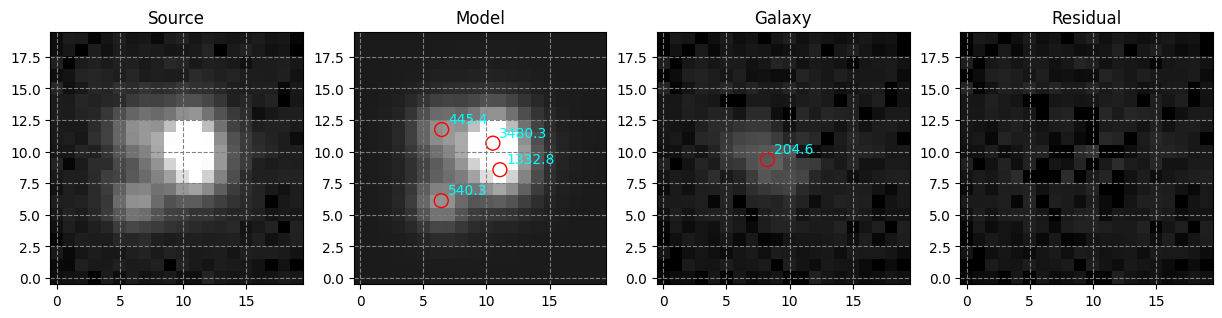

In [209]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(141)
norm = simple_norm(src.data, 'sqrt', percent=95.0)
ax1.imshow(src.data, origin='lower', cmap='gray', norm=norm)
ax1.grid(True, color='gray', linestyle='--')
ax1.set_title('Source')
ax2 = fig.add_subplot(142)
ax2.imshow(model_src(x, y), origin='lower', cmap='gray', norm=norm)
for model in model_src:
    if model.name.startswith('moffat'):
        ax2.scatter(model.x_0.value, model.y_0.value, s=100, edgecolor='red', facecolor='none')
        ax2.annotate(f"{model.amplitude.value:.1f}", (model.x_0.value+0.5, model.y_0.value+0.5), color='cyan')
ax2.grid(True, color='gray', linestyle='--')
ax2.set_title('Model')
ax3 = fig.add_subplot(143)
galaxy = src.data - model_src[:-1](x, y)
ax3.imshow(galaxy, origin='lower', cmap='gray', norm=norm)
for model in model_src:
    if model.name.startswith('gaussian'):
        ax3.scatter(model.x_mean.value, model.y_mean.value, s=100, edgecolor='red', facecolor='none')
        ax3.annotate(f"{model.amplitude.value:.1f}", (model.x_mean.value+0.5, model.y_mean.value+0.5), color='cyan')
ax3.grid(True, color='gray', linestyle='--')
ax3.set_title('Galaxy')
ax4 = fig.add_subplot(144)
residual = src.data - model_src(x, y)
ax4.imshow(residual, origin='lower', cmap='gray', norm=norm)
ax4.grid(True, color='gray', linestyle='--')
ax4.set_title('Residual')
plt.show()

# Plot the GLS model

Name    dx        dy     mag
A:    0.598,    0.345, 19.316
B:    0.744,   -0.206, 20.358
C:   -0.474,   -0.849, 21.338
D:   -0.465,    0.627, 21.548
G:    0.000,    0.000, 22.740


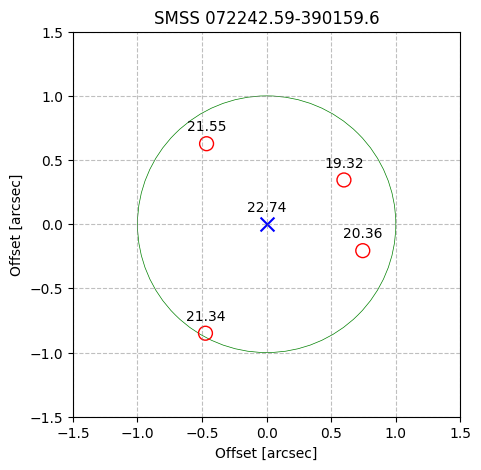

In [280]:
components = ['A', 'B', 'C', 'D', 'G']
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(
    # projection=wcs
    )
x0, y0 = model_src[-1].x_mean.value, model_src[-1].y_mean.value
# plt.scatter(0, 0, s=100, color='blue', marker='x')

print("Name    dx        dy     mag")
circle = plt.Circle((0, 0), 1.0, color='green', fill=False, lw=0.5)
ax.add_artist(circle)
i = 0
for model in model_src:
    if model.name.startswith('moffat'):
        dx = (model.x_0.value - x0) * scale
        dy = (model.y_0.value - y0) * scale
        component_flux = model.amplitude.value * np.pi * model.gamma.value ** 2
        mag = psf_g_mag - 2.5 * np.log10(component_flux / psf_flux)
        print(f"{components[i]}: {dx:>8.3f}, {dy:>8.3f}, {mag:.3f}")
        ax.scatter((model.x_0.value - x0) * scale, 
                   (model.y_0.value - y0) * scale,
                   s=100, edgecolor='red', facecolor='none')
        ax.annotate(f"{mag:.2f}", 
                    (dx+0.0, dy+0.1), 
                    ha='center',
                    color='black')
        i += 1
    elif model.name.startswith('gaussian'):
        dx = (model.x_mean.value - x0) * scale
        dy = (model.y_mean.value - y0) * scale
        component_flux = model.amplitude.value * 2 * np.pi * model.x_stddev.value * model.y_stddev.value
        mag = psf_g_mag - 2.5 * np.log10(component_flux / psf_flux)
        print(f"{components[i]}: {dx:>8.3f}, {dy:>8.3f}, {mag:.3f}")
        ax.scatter(0, 0, s=100, color='blue', marker='x')
        ax.annotate(f"{mag:.2f}", 
                    (0.0, 0.1), color='black', ha='center')
plt.grid(ls='--', color='gray', alpha=0.5)
pn = 1.5
plt.xlim(-pn, pn)
plt.ylim(-pn, pn)
plt.xlabel('Offset [arcsec]')
plt.ylabel('Offset [arcsec]')
plt.title('SMSS 072242.59-390159.6')
plt.show()